# Tropical cyclone Rapid Intensification (RI) classification

In [ ]:
import keras
import pickle
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.DataFrame(pd.read_csv("global.csv"))
df = df.drop(['date', 'hour'], axis = 1)
#df

In [3]:
feat = ['vs0', 'PSLV_v2', 'PSLV_v3', 'PSLV_v4', 'PSLV_v5', 'PSLV_v6', 'PSLV_v7',
        'PSLV_v8', 'PSLV_v10', 'PSLV_v11', 'PSLV_v12', 'PSLV_v13',
        'PSLV_v14', 'PSLV_v15', 'PSLV_v16', 'PSLV_v17', 'PSLV_v18', 'PSLV_v19',
        'MTPW_v2', 'MTPW_v3', 'MTPW_v4', 'MTPW_v5', 'MTPW_v6', 'MTPW_v7',
        'MTPW_v8', 'MTPW_v9', 'MTPW_v10', 'MTPW_v11', 'MTPW_v12', 'MTPW_v13',
        'MTPW_v14', 'MTPW_v15', 'MTPW_v16', 'MTPW_v17', 'MTPW_v18', 'MTPW_v19',
        'MTPW_v20', 'MTPW_v21', 'MTPW_v22', 'IR00_v2', 'IR00_v3', 'IR00_v4',
        'IR00_v5', 'IR00_v6', 'IR00_v7', 'IR00_v8', 'IR00_v9', 'IR00_v10',
        'IR00_v11', 'IR00_v12', 'IR00_v13', 'IR00_v14', 'IR00_v15', 'IR00_v16',
        'IR00_v17', 'IR00_v18', 'IR00_v19', 'IR00_v20', 'IR00_v21', 'CSST_t24',
        'CD20_t24', 'CD26_t24', 'COHC_t24', 'DTL_t24', 'RSST_t24', 'U200_t24',
        'U20C_t24', 'V20C_t24', 'E000_t24', 'EPOS_t24', 'ENEG_t24', 'EPSS_t24',
        'ENSS_t24', 'RHLO_t24', 'RHMD_t24', 'RHHI_t24', 'Z850_t24', 'D200_t24',
        'REFC_t24', 'PEFC_t24', 'T000_t24', 'R000_t24', 'Z000_t24', 'TLAT_t24',
        'TLON_t24', 'TWAC_t24', 'TWXC_t24', 'G150_t24', 'G200_t24', 'G250_t24',
        'V000_t24', 'V850_t24', 'V500_t24', 'V300_t24', 'TGRD_t24', 'TADV_t24',
        'PENC_t24', 'SHDC_t24', 'SDDC_t24', 'SHGC_t24', 'DIVC_t24', 'T150_t24',
        'T200_t24', 'T250_t24', 'SHRD_t24', 'SHTD_t24', 'SHRS_t24', 'SHTS_t24',
        'SHRG_t24', 'PENV_t24', 'VMPI_t24', 'VVAV_t24', 'VMFX_t24', 'VVAC_t24',
        'HE07_t24', 'HE05_t24', 'O500_t24', 'O700_t24', 'CFLX_t24', 'DELV-12',
        'dvs24']

new_feat_AL = ['vs0','PSLV_v6','PSLV_v7','MTPW_v18','MTPW_v20',
               'IR00_v7','IR00_v11','IR00_v18','CD20_t24','COHC_t24',
               'DTL_t24','RSST_t24','U20C_t24','RHMD_t24','T000_t24',
               'Z000_t24','TLAT_t24','TWXC_t24','V500_t24','V300_t24',
               'SHGC_t24','T250_t24','VVAC_t24','HE05_t24','DELV-12','dvs24']

new_feat_WP = ['vs0','PSLV_v5','PSLV_v8','PSLV_v10','PSLV_v15',
              'MTPW_v3','MTPW_v10','MTPW_v12','MTPW_v19','MTPW_v20',
              'IR00_v7','CD20_t24','DTL_t24','V20C_t24','ENSS_t24',
              'RHHI_t24','TLAT_t24','TWAC_t24','SHGC_t24', 'SHTS_t24',
               'PENV_t24','VVAC_t24','DELV-12','dvs24']                 # In conjunction with SFS and Pearson corr.

In [44]:
#df1 = pd.DataFrame(df, columns = feat) 
#df1 = pd.DataFrame(df.iloc[44660:54960], columns = new_feat_AL)   # Atlantic ocean (1982-2016 train)
df1 = pd.DataFrame(df.iloc[26616:44204], columns = feat)   # western pacific (1990-2016 train)
df1 = df1.dropna(axis = 1)
df1

,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,PSLV_v10,PSLV_v11,...,VVAV_t24,VMFX_t24,VVAC_t24,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,DELV-12,dvs24
26616,30,565,-56.0,15.0,-59.0,15.0,-57.0,15.0,26.0,51.0,...,511.000000,439.00000,972.000000,2.000000,-13.000000,-97.000000,-64.000000,138.000000,5.004258,15.012775
26617,30,547,-56.0,23.0,-56.0,23.0,-56.0,23.0,28.0,56.0,...,633.000000,523.00000,870.000000,-15.000000,-11.000000,-111.000000,-98.000000,110.000000,0.000000,25.021292
26618,30,565,-53.0,31.0,-52.0,39.0,-53.0,35.0,32.0,74.0,...,504.000000,439.00000,678.000000,1.000000,18.000000,5.000000,-17.000000,122.000000,0.000000,30.025550
26619,35,543,-51.0,39.0,-38.0,46.0,-43.0,43.0,43.0,90.0,...,393.000000,364.00000,637.000000,2.000000,6.000000,-42.000000,-57.000000,160.000000,5.004258,30.025550
26620,45,530,-45.0,44.0,-40.0,41.0,-42.0,43.0,33.0,69.0,...,413.000000,384.00000,360.000000,5.000000,-27.000000,-77.000000,-75.000000,260.000000,15.012775,20.017033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44199,70,505,-60.0,28.0,-57.0,20.0,-60.0,26.0,29.0,62.0,...,389.000000,375.00000,295.000000,169.000000,217.000000,-1.000000,-10.000000,299.000000,-15.000000,-35.000000
44200,65,567,-65.0,21.0,-43.0,30.0,-50.0,24.0,47.0,55.0,...,532.000000,486.00000,391.000000,185.000000,270.000000,4.000000,-15.000000,267.000000,-10.000000,-35.000000
44201,55,597,-57.0,13.0,-39.0,32.0,-44.0,15.0,47.0,61.0,...,536.000000,489.00000,493.000000,93.000000,138.000000,-14.000000,-22.000000,243.000000,-15.000000,-30.000000
44202,25,552,-30.0,21.0,-49.0,10.0,-36.0,14.0,19.0,18.0,...,390.000000,363.00000,1016.000000,-1.000000,-6.000000,-51.000000,-56.000000,106.000000,5.004258,0.000000


In [45]:
cols = list(df1)[:]
df_train = df1[cols].astype(float)

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)

In [46]:
xtrain_svc = df_train_scaled[:, :-1]   # SVC training input 

In [47]:
ytrain_svc = np.array(df_train['dvs24'])

for i in range(len(ytrain_svc)):
    if ytrain_svc[i] >= 30:
        ytrain_svc[i] = 1
    else:
        ytrain_svc[i] = 0
        
ytrain_svc[:500]               # Actual RI, UNRI labels       

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
df3 = pd.DataFrame(df.iloc[44204:44662], columns = feat)   # WP 2017
#df3 = pd.DataFrame(df.iloc[54960:55370], columns = new_feat_AL)   # AL 2017
#df3['dvs24'] = round(df3['dvs24'], 0)

#df3 = pd.DataFrame(pd.read_csv("NOAA_operational_vars_global_w_dvs24.csv"))  # operational AL 2010-16
#df3 = pd.DataFrame(df3, columns = new_feat_AL)
#df3 = df3.dropna(axis = 1)
#df3 = df3.drop(['E000_t24', 'V20C_t24'], axis = 1)

#df3 = pd.DataFrame(pd.read_csv("atlantic_2019-20.csv"))  # operational AL 2019-20
#df3 = pd.DataFrame(df3, columns = new_feat_AL)
df3

,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,PSLV_v10,PSLV_v11,...,VVAV_t24,VMFX_t24,VVAC_t24,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,DELV-12,dvs24
44204,30,539,-30.0,21.0,-50.0,11.0,-37.0,12.0,14.0,22.0,...,778.257686,558.72829,842.494451,-1.966256,-2.430744,-55.408076,-49.325966,237.445738,5.004258,-10.008517
44205,30,600,-28.0,13.0,-48.0,16.0,-33.0,12.0,13.0,18.0,...,778.257686,558.72829,842.494451,-1.966256,-2.430744,-55.408076,-49.325966,237.445738,5.004258,-10.008517
44206,25,616,-25.0,10.0,-53.0,16.0,-33.0,8.0,8.0,5.0,...,778.257686,558.72829,842.494451,-1.966256,-2.430744,-55.408076,-49.325966,237.445738,-5.004258,-5.004258
44207,25,724,-15.0,-13.0,-42.0,26.0,-15.0,-5.0,15.0,-21.0,...,778.257686,558.72829,842.494451,-1.966256,-2.430744,-55.408076,-49.325966,237.445738,5.004258,-5.004258
44208,25,750,-13.0,-18.0,-45.0,24.0,-14.0,-10.0,11.0,-40.0,...,778.257686,558.72829,842.494451,-1.966256,-2.430744,-55.408076,-49.325966,237.445738,5.004258,-10.008517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44657,85,529,-66.0,5.0,-68.0,-2.0,-69.0,1.0,28.0,52.0,...,167.000000,178.00000,246.000000,71.000000,95.000000,-32.000000,-55.000000,-50.000000,15.000000,-40.000000
44658,75,558,-66.0,5.0,-73.0,0.0,-72.0,0.0,26.0,46.0,...,206.000000,214.00000,273.000000,83.000000,93.000000,-26.000000,-42.000000,58.000000,-5.000000,-35.000000
44659,65,614,-59.0,0.0,-73.0,6.0,-67.0,-2.0,22.0,34.0,...,334.000000,322.00000,377.000000,12.000000,13.000000,-45.000000,-66.000000,33.000000,-20.000000,-35.000000
44660,20,548,31.0,23.0,24.0,13.0,28.0,16.0,23.0,64.0,...,808.000000,605.00000,548.000000,60.000000,25.000000,-86.000000,-81.000000,150.000000,0.786585,30.025550


In [49]:
cols2 = list(df3)[:]
df_test = df3[cols2].astype(float)
df_test_scaled = scaler.fit_transform(df_test)

In [50]:
xtest_svc = df_test_scaled[:, :-1]  # SVC test data

In [51]:
ytest_svc = np.array(df3['dvs24'])

for i in range(len(ytest_svc)):
    if ytest_svc[i] >= 30:
        ytest_svc[i] = 1
    else:
        ytest_svc[i] = 0
        
print(ytest_svc[:500])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.

# Classification using SVC

In [52]:
sm = SMOTE(random_state = 42, sampling_strategy = {0: 16172, 1: 4043}, k_neighbors = 10)  # AL(9768, 2442), WP(16172, 4043)
x_resample, y_resample = sm.fit_resample(xtrain_svc, ytrain_svc)

In [53]:
start = time.time()

svc = SVC(kernel = 'rbf', gamma = 0.001, C = 5, verbose = True)

#classifier = svc.fit(xtrain_svc, ytrain_svc)    # Before SMOTE
classifier = svc.fit(x_resample, y_resample)   # After SMOTE

end = time.time()
print('Time elapsed:', (end - start) / 60, 'min')

[LibSVM]Time elapsed: 0.28645875056584674 min


In [72]:
svc_train_out = classifier.predict(xtrain_svc)  # To be fed into the neural network!!!

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

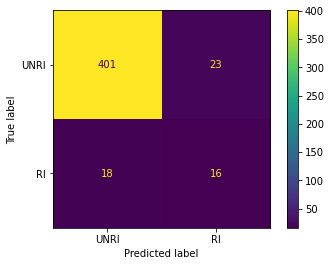

In [54]:
ypredict = classifier.predict(xtest_svc)  
print(ypredict)
print(classification_report(ytest_svc, ypredict))
cm = confusion_matrix(ytest_svc, ypredict)
display = ConfusionMatrixDisplay(cm, display_labels = ['UNRI', 'RI'])
display.plot()
plt.show()

# Neural network training

In [55]:
ytrain_svc_reshape = ytrain_svc.reshape(-1, 1)
#svc_train_reshape = svc_train_out.reshape(-1, 1)                      #For Neural network

xtrain_nn = np.concatenate([xtrain_svc, ytrain_svc_reshape], axis = 1) #Put either 'ytrain_svc_reshape' or 'svc_train_reshape') 
ytrain_nn = df_train_scaled[:, -1]     

In [63]:
model = Sequential()
model.add(Dense(60, input_dim = xtrain_nn.shape[1], activation = 'relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(30, activation = 'sigmoid'))
#model.add(Dropout(0.3))
#model.add(Dense(30, activation = 'sigmoid'))
model.add(Dense(1))

model.compile(loss = 'mae', optimizer = Adam(learning_rate = 0.001))

early = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, 
                      verbose = 1, restore_best_weights = True)
history = model.fit(xtrain_nn, ytrain_nn, epochs = 100, batch_size = 64, validation_split = 0.2,
                   callbacks = early, verbose = 1)


Epoch 1/100
220/220 [==============================] - 1s 2ms/step - loss: 0.5225 - val_loss: 0.4919
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 0.4263 - val_loss: 0.4704
Epoch 3/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3944 - val_loss: 0.4680
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3766 - val_loss: 0.4381
Epoch 5/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3670 - val_loss: 0.4140
Epoch 6/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3582 - val_loss: 0.4151
Epoch 7/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3546 - val_loss: 0.4168
Epoch 8/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3472 - val_loss: 0.4169
Epoch 9/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3454 - val_loss: 0.4024
Epoch 10/100
220/220 [==============================] - 0s 2ms/step - loss: 0.3402 - val_lo

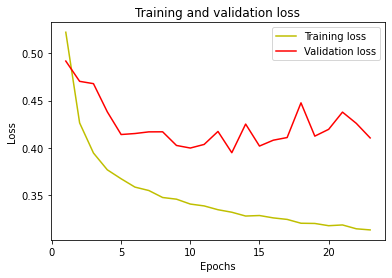

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing 

In [65]:
svc_test_reshape = ypredict.reshape(-1, 1)
xtest_nn = np.concatenate([xtest_svc, svc_test_reshape], axis = 1)
ytest_nn = df_test_scaled[:, -1]

In [66]:
print('\n')
model.evaluate(xtest_nn, ytest_nn)
predictions = model.predict(xtest_nn)
predict_copies = np.repeat(predictions, df3.shape[1], axis = -1)
predictions2 = scaler.inverse_transform(predict_copies)[:, -1]
ytestdf = df3['dvs24']
ytest_arr = np.array(ytestdf)



15/15 [==============================] - 0s 1ms/step - loss: 0.4717


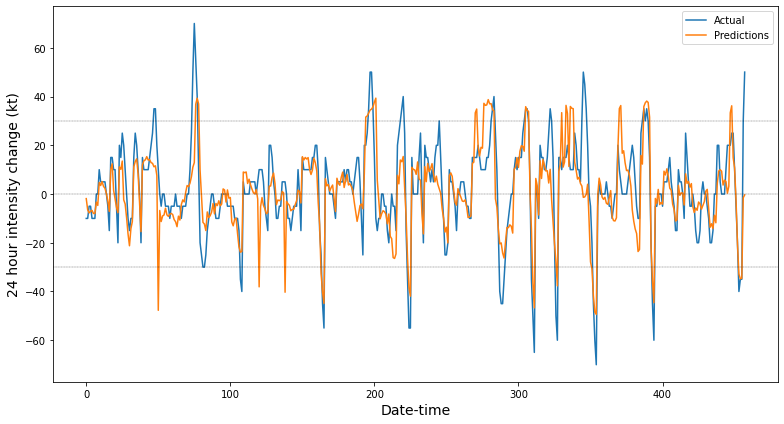

In [67]:
plt.figure(figsize = (11, 6))
plt.plot(ytest_arr, label = 'Actual')  # np.arange(0, len(ytest_arr), 1)
plt.plot(predictions2, label = 'Predictions')
plt.ylabel('24 hour intensity change (kt)', fontsize = 14)
plt.xlabel('Date-time', fontsize = 14)
plt.axhline(y=0, color = 'black', linestyle='--', linewidth = 0.3)
plt.axhline(y=30, color = 'black', linestyle='--', linewidth = 0.3)
plt.axhline(y=-30, color = 'black', linestyle='--', linewidth = 0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Rapid Intensification and weakening cases analysis

In [68]:
total_ri, true_positives, false_positives, true_negatives, false_negatives = [],[],[],[],[]

for i, j in zip(range(len(ytest_arr)), range(len(predictions2))):
    if ytest_arr[i] >= 30:
        total_ri.append(ytest_arr[i])
        if predictions2[i] >= 30:
            true_positives.append(predictions2[i])
        else:
            false_negatives.append(predictions2[i])
    if ytest_arr[i] < 30:
        if predictions2[i] >= 30:
            false_positives.append(predictions2[i])
        else:
            true_negatives.append(predictions2[i])
            
accuracy = ((len(true_positives) + len(true_negatives)) / 
           (len(true_positives) + len(true_negatives) + 
            len(false_positives) + len(false_negatives)))

pod = len(true_positives) / (len(true_positives) + len(false_negatives))
far = len(false_positives) / (len(true_positives) + len(false_positives))
#pofd = len(false_positives) / (len(true_positives) + len(false_positives))
#pss = pod - pofd 
        
print('\nTotal RI cases:', len(total_ri))
print('True positives:', len(true_positives))
print('False positives:', len(false_positives))
print('True negatives :', len(true_negatives))
print('False negatives:', len(false_negatives))
print('POD:', pod)
print('FAR:',far)
print('\naccuracy:', accuracy)
#print('POFD:', pofd)
#print('PSS score:', pss)


Total RI cases: 34
True positives: 16
False positives: 23
True negatives : 401
False negatives: 18
POD: 0.47058823529411764
FAR: 0.5897435897435898

accuracy: 0.9104803493449781


In [69]:
# Metrics of testing evaluations

mae = np.sum(np.abs(predictions2 - ytest_arr)) / len(ytest_arr)
print('\nMAE:', np.round(mae, 2), 'kt')
rmse = np.sqrt(np.sum((predictions2 - ytest_arr) ** 2) / len(ytest_arr))
print('RMSE:', np.round(rmse, 2), 'kt')
r2 = round(r2_score(ytest_arr, predictions2), 3)
print('R^2 value:', r2)


MAE: 8.96 kt
RMSE: 12.89 kt
R^2 value: 0.539
